# Fit Data to a mixutre of Gaussian distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mog_class import MoG_class,MoG_indep_class
from util import nzr
%matplotlib inline  
print ("Packages loaded.")

Packages loaded.


### GMM with 'MoG_indep_class'
- Let each output dimension to have each mixture probabilities'

In [2]:
# Instantiate MoG class
tf.reset_default_graph() # Reset graph
sess = tf.Session()
M = MoG_indep_class(_x_dim=2,_k=5,_sess=sess)
print ("MoG class instantiated.")

MoG class instantiated.


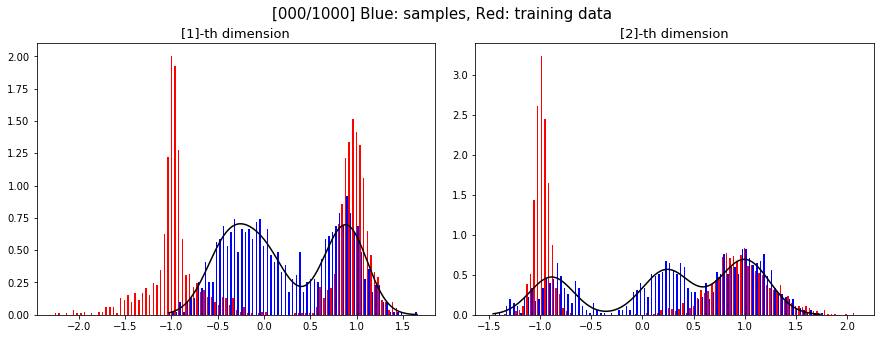

[000/1000] cost:2.1543


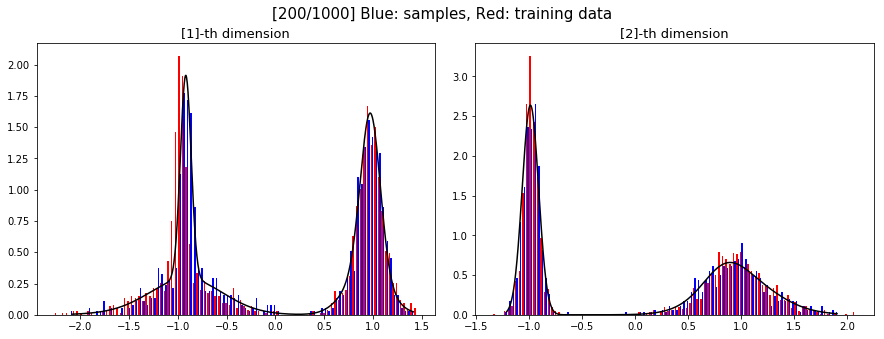

[200/1000] cost:0.3578


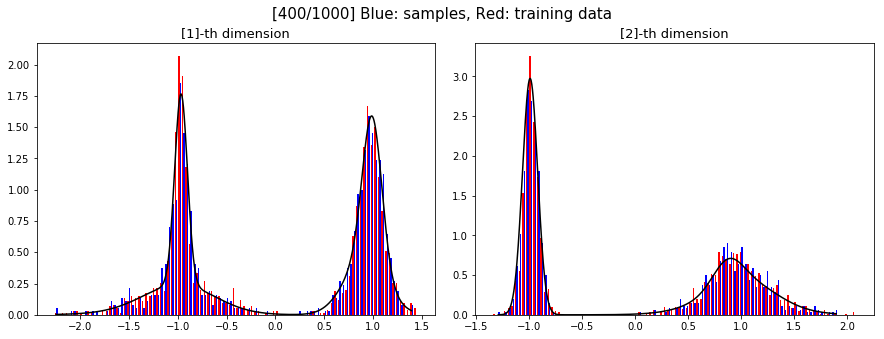

[400/1000] cost:0.2033


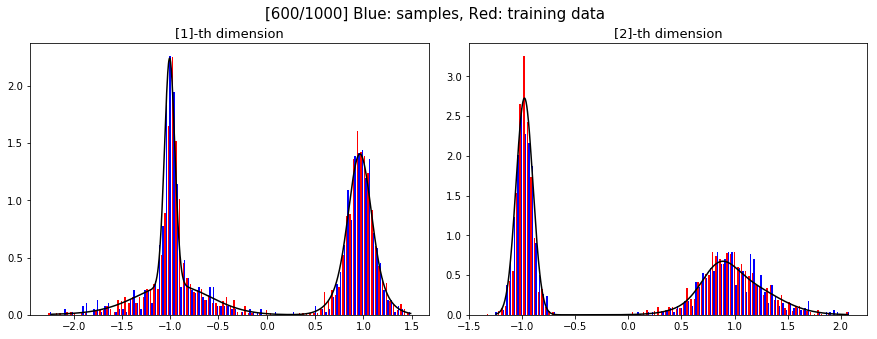

[600/1000] cost:0.1946


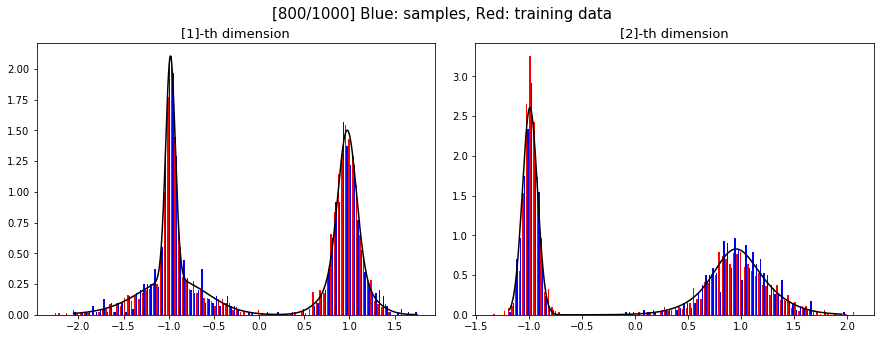

[800/1000] cost:0.3024


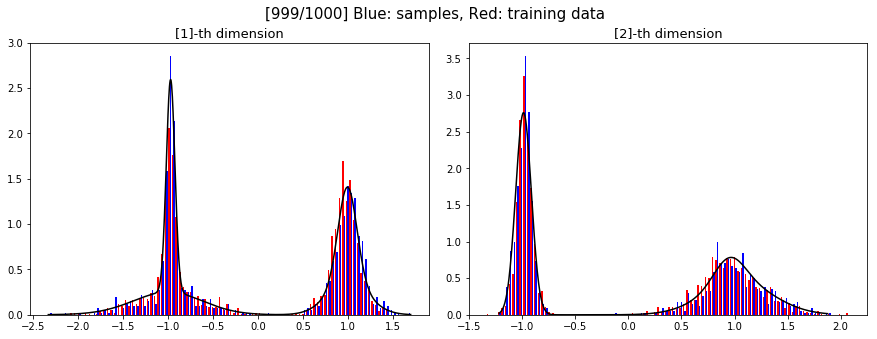

[999/1000] cost:0.2698


In [3]:
# Training data
mu1,mu2,mu3,mu4 = np.array([10,0]),np.array([10,10]),np.array([0,10]),np.array([0,0])
var1,var2,var3,var4 = 1/4,1,4,1/16
n1,n2,n3,n4 = 500,500,500,500
x_train = np.concatenate((mu1+np.sqrt(var1)*np.random.randn(n1,2),
                          mu2+np.sqrt(var2)*np.random.randn(n2,2),
                          mu3+np.sqrt(var3)*np.random.randn(n3,2),
                          mu4+np.sqrt(var4)*np.random.randn(n4,2)))
n_train = x_train.shape[0]
x_train = nzr(x_train).nzd_data # normalize training data 
# Train
max_iter = 1000
for iter in range(max_iter):
    x_batch = x_train[np.random.permutation(n_train)[:128],:] # current batch
    _,cost_val = M.sess.run([M.optm,M.cost],feed_dict={M.x:x_batch})
    # Debug 
    if ((iter%(max_iter//5))==0) | (iter==(max_iter-1)):
        M.plot_samples(_n_sample=1000,_x_train=x_train,
                       _title_str='[%03d/%d] Blue: samples, Red: training data'%(iter,max_iter),
                       _figsize=(15,5))
        print ("[%03d/%d] cost:%.4f"%(iter,max_iter,cost_val))

### Train GMM with 'MoG_class'
- Let each mixture to model multivariate Gaussian

In [4]:
# Instantiate MoG class
tf.reset_default_graph() # Reset graph
sess = tf.Session()
M = MoG_class(_x_dim=2,_k=5,_sess=sess)
print ("MoG class instantiated.")

MoG class instantiated.


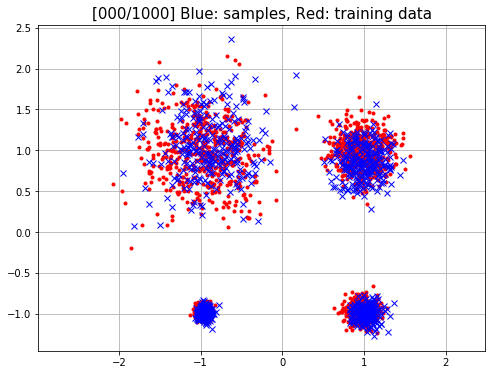

[000/1000] cost:0.3535


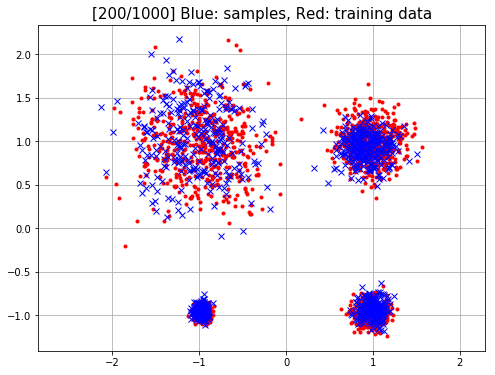

[200/1000] cost:0.2294


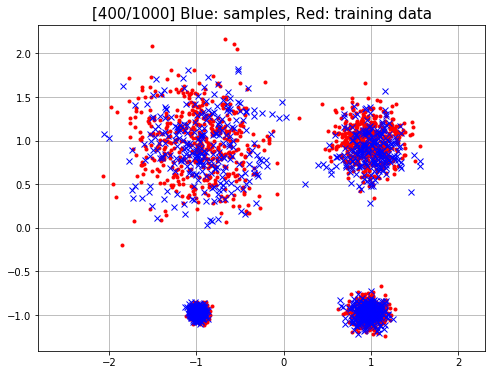

[400/1000] cost:0.1592


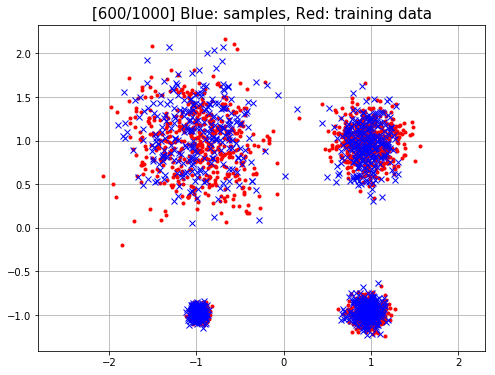

[600/1000] cost:0.3600


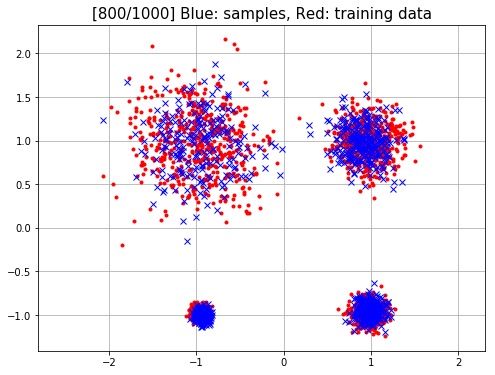

[800/1000] cost:0.3959


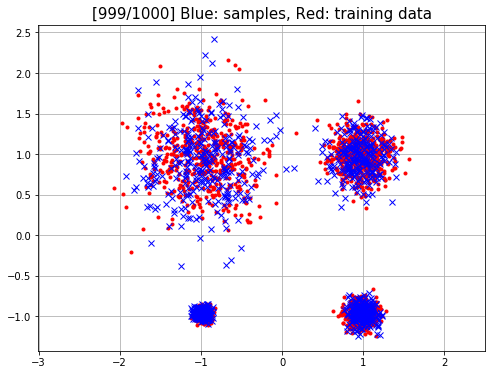

[999/1000] cost:0.2765


In [6]:
# Training data
mu1,mu2,mu3,mu4 = np.array([10,0]),np.array([10,10]),np.array([0,10]),np.array([0,0])
var1,var2,var3,var4 = 1/4,1,4,1/16
n1,n2,n3,n4 = 500,500,500,500
x_train = np.concatenate((mu1+np.sqrt(var1)*np.random.randn(n1,2),
                          mu2+np.sqrt(var2)*np.random.randn(n2,2),
                          mu3+np.sqrt(var3)*np.random.randn(n3,2),
                          mu4+np.sqrt(var4)*np.random.randn(n4,2)))
n_train = x_train.shape[0]
x_train = nzr(x_train).nzd_data # normalize training data 
# Train
max_iter = 1000
for iter in range(max_iter):
    x_batch = x_train[np.random.permutation(n_train)[:128],:] # current batch
    _,cost_val = M.sess.run([M.optm,M.cost],feed_dict={M.x:x_batch})
    # Debug 
    if ((iter%(max_iter//5))==0) | (iter==(max_iter-1)):
        M.plot_samples(_n_sample=1000,_x_train=x_train,
                       _title_str='[%03d/%d] Blue: samples, Red: training data'%(iter,max_iter))
        print ("[%03d/%d] cost:%.4f"%(iter,max_iter,cost_val))